# Constraint plots

## Imports

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from scipy.stats import norm

%run _color_tools.ipynb

Global variables:
 	- C: color palette
 	- cm: cm to inch conversion factor


## Load data

In [32]:
df = pd.read_csv("../outputs/expected_variants_all_regions_stats.tsv", sep="\t")

## Expected variants per transcript

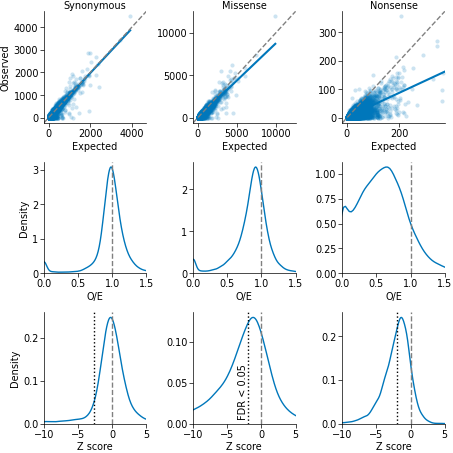

In [33]:
csq = ["synonymous", "missense", "nonsense"]

fig, axs = plt.subplots(3, 3, figsize=(120 / 25.4, 120 / 25.4), layout="tight")

# Expected variants per transcript
for c, (i, ax) in zip(csq, enumerate(axs[0])):
    sns.regplot(
        ax=ax,
        data=df[
            (df["region"] == "transcript")
            & (df.enst != "ENST00000589042")  # Exclude TTN
            & (df["csq"] == c)
        ],
        x="n_exp",
        y="n_obs",
        ci=None,
        scatter_kws=dict(alpha=0.2),
    )

    ax.axline((0, 0), (1, 1), color="grey", linestyle="--")
    ax.set_title(
        c.capitalize(),
    )
    ax.set_xlabel("Expected")
    ax.set_xlim(ax.get_ylim())
    if i == 0:
        ax.set_ylabel("Observed")
    else:
        ax.set_ylabel(None)

# O/E per transcript
for c, (i, ax) in zip(csq, enumerate(axs[1])):
    sns.kdeplot(
        ax=ax,
        data=df[(df["region"] == "transcript") & (df["csq"] == c)],
        x="oe",
        gridsize=1000,
    )
    ax.set_xlabel("O/E")
    ax.set_xlim((0, 1.5))
    ax.axvline(
        x=1,
        color="gray",
        linestyle="--",
    )
    if i == 0:
        ax.set_ylabel("Density")
    else:
        ax.set_ylabel(None)

# Z scores per transcript
for c, (i, ax) in zip(csq, enumerate(axs[2])):

    _df = df[(df["region"] == "transcript") & (df["csq"] == c)]

    # Find the highest P value which remains significant after FDR correction
    m1 = _df["fdr_p"] < 0.05
    max_p = _df[m1]["p"].max()
    sig_thresh = norm.isf(1 - max_p)

    # KDE plot
    ax = sns.kdeplot(
        ax=ax,
        data=_df,
        x="z",
        gridsize=1000,
    )

    # Add line for Z = 0
    ax.axvline(
        x=0,
        color="gray",
        linestyle="--",
    )

    # Add line for FDR threshold
    ax.axvline(
        x=sig_thresh,
        color=C.black,
        linestyle=":",
        label="FDR < 0.05",
    )

    if i == 1:
        ax.text(
            x=sig_thresh,
            y=0.005,
            ha="right",
            va="bottom",
            s="FDR < 0.05",
            rotation=90,
            # transform=ax.get_xaxis_transform(),
        )

    # Axis labels and limits
    ax.set_xlabel("Z score")
    ax.set_xlim((-10, 5))

    if i == 0:
        ax.set_ylabel("Density")
    else:
        ax.set_ylabel(None)

# Save figure
plt.savefig("../plots/constraint_in_transcripts_by_csq_combined.svg", format="svg")
plt.savefig(
    "../plots/constraint_in_transcripts_by_csq_combined.png", format="png", dpi=1000
)

## Nonsense P values by region, before and after FDR correction

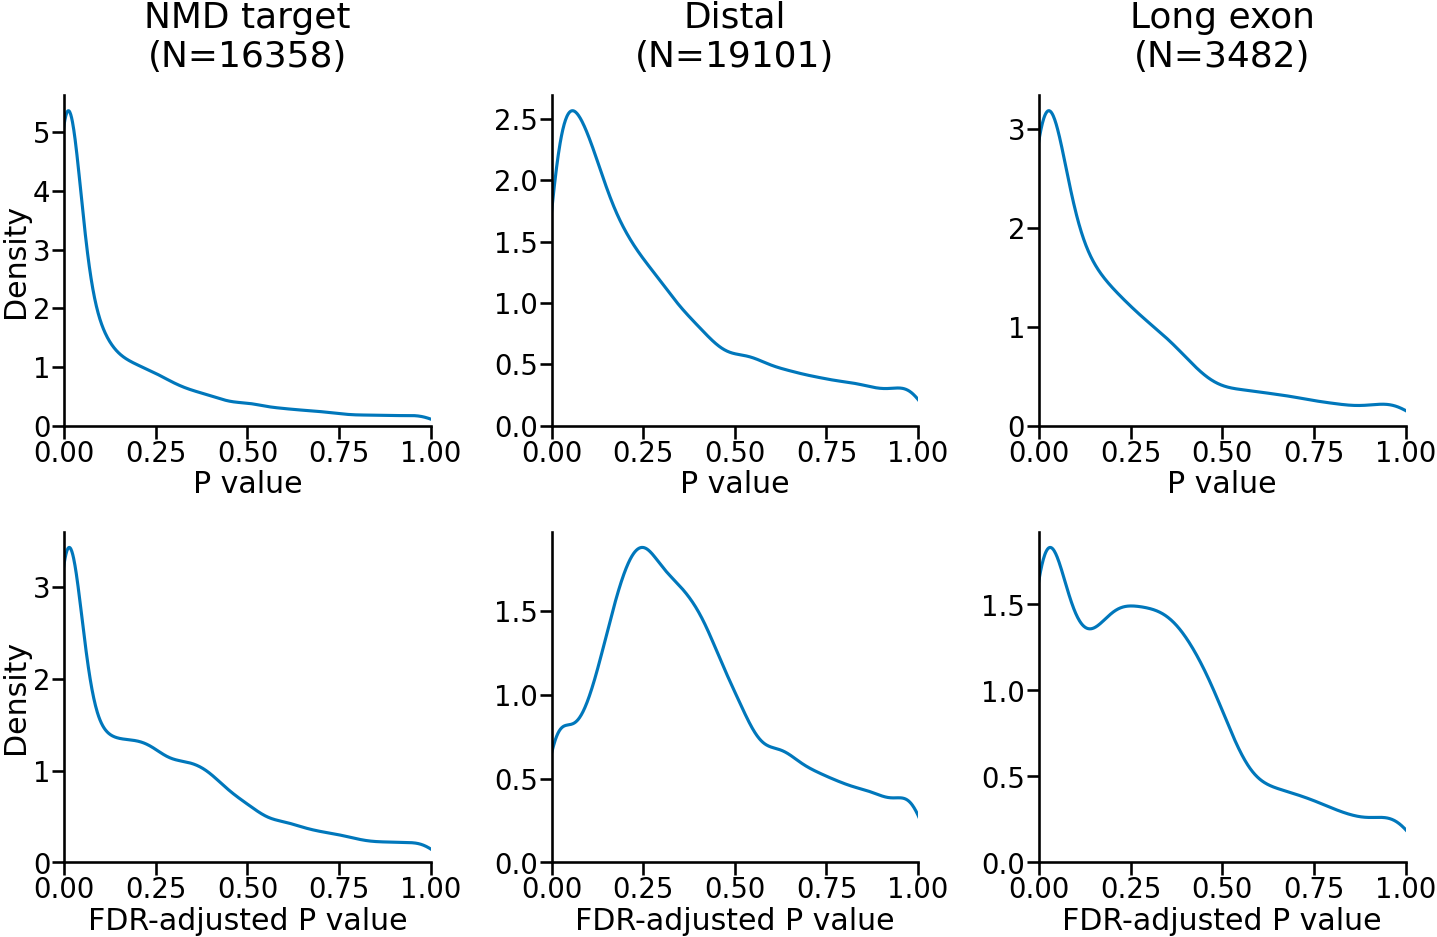

In [7]:
regions = ["nmd_target", "distal_nmd", "long_exon"]
regions_title = ["NMD target", "Distal", "Long exon"]
number = [
    df.loc[(df.region == r) & (df.csq == "nonsense"), "p"].count() for r in regions
]

fig, axs = plt.subplots(2, 3, figsize=(15, 10), layout="tight")

# Raw P values
for r, rt, n, (i, ax) in zip(regions, regions_title, number, enumerate(axs[0])):
    sns.kdeplot(
        ax=ax,
        data=df[(df.csq == "nonsense") & (df["region"] == r)],
        x="p",
        gridsize=1000,
    )
    ax.set_xlim(0, 1)
    ax.set_xlabel("P value")
    ax.set_title(f"{rt}\n(N={n})", pad=20, fontsize="large")

    if i == 0:
        ax.set_ylabel("Density")
    else:
        ax.set_ylabel(None)

# FDR-adjusted P values
for r, rt, n, (i, ax) in zip(regions, regions_title, number, enumerate(axs[1])):
    sns.kdeplot(
        ax=ax,
        data=df[(df.csq == "nonsense") & (df["region"] == r)],
        x="fdr_p",
        gridsize=1000,
    )
    ax.set_xlim(0, 1)
    ax.set_xlabel("FDR-adjusted P value")

    if i == 0:
        ax.set_ylabel("Density")
    else:
        ax.set_ylabel(None)

# Figure level changes
for ax in axs:
    for a in ax:
        a.spines["top"].set_color("None")
        a.spines["right"].set_color("None")

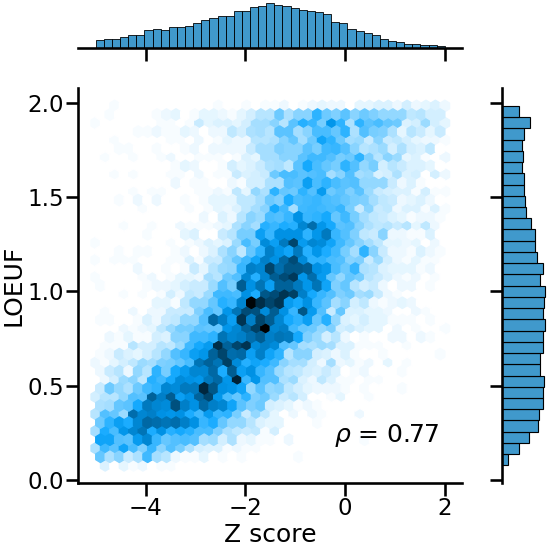

In [8]:
sns.set_context("talk", font_scale=1)

g = sns.jointplot(
    data=df[
        (df["csq"] == "nonsense")
        & (df["z"].between(-5, 2))
        & (df["region"] == "transcript")
    ],
    x=("z"),
    y="loeuf",
    kind="hex",
)
g.set_axis_labels(
    xlabel="Z score",
    ylabel="LOEUF",
)
g.fig.tight_layout()
g.fig.text(x=0.6, y=0.22, s=r"$\rho$ = 0.77", fontsize="medium")
# g.fig.text(x=0.52, y=0.18, s=r"P < 2.2$\times 10^{-328}$", fontsize="medium")

plt.savefig("../plots/constraint_z_vs_loeuf.svg", format="svg")